In [1]:
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않음, 모든 훈련 연산 비활성화
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights = 'imagenet',
                                 include_top = False)

# 경사상승으로 최대화할 값
# 모든 필터를 동시에 최대화함
# L2norm 가중치 합최대화
# 하위층은 기하학적, 상위층은 class로 보이는 시각요소 만듦

Using TensorFlow backend.














87916544/87910968 [==============================] - 4s 0us/step


In [2]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
# 층 이름과 계수를 매핑한 딕셔너리
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정함
# 층은 V3 app에 하드코딩됨
layer_contributions = {
    'mixed2' : 1.,
    'mixed3' : 2.,
    'mixed4' : 3.,
    'mixed5' : 4.5,
    'mixed6' : 5.5,
    'mixed7' : 6.5,
    'mixed8' : 7.5,
    'mixed10' : 8,}

In [105]:
# 손실텐서 정의
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의, 각 층의 기여분을 이 스칼라 변수에 추가
loss = K.variable(0.)

for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]

  # 층의 출력을 얻음
  activation = layer_dict[layer_name].output

  scaling = K.prod(K.cast(K.shape(activation), 'float32'))

  # 층 특성 L2 norm 제곱을 손실에 추가, 이미지 테두리는 제외
  loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [0]:
# 딥드림 이미지 저장
dream = model.input
# 손실에 대한 딥드림 이미지 그래디언트 계산
grads = K.gradients(loss, dream)[0]

# 그래디언트 정규화
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 함수를 생성
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss = None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('...', i, '번째 손실: ', loss_value)
    x += step * grad_values
  return x

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

In [0]:
# 스케일을 늘리고 디테일을 주입하는 식
# 경사 상승법 이후 이미지 크기가 40%까지 증가됨

In [0]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [111]:
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = '/content/Flowers at the fence.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/content/ju1.png')

처리할 이미지 크기 (204, 326)
... 0 번째 손실:  3.395822
... 1 번째 손실:  5.306716
... 2 번째 손실:  6.063729
... 3 번째 손실:  7.057436
... 4 번째 손실:  6.174918
... 5 번째 손실:  6.3747993
... 6 번째 손실:  7.474711
... 7 번째 손실:  8.648088
... 8 번째 손실:  8.67054
... 9 번째 손실:  9.727053
처리할 이미지 크기 (285, 457)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


... 0 번째 손실:  5.20189
... 1 번째 손실:  8.292188
처리할 이미지 크기 (400, 640)
... 0 번째 손실:  5.920763
... 1 번째 손실:  6.6595573
... 2 번째 손실:  6.9094086
... 3 번째 손실:  8.752032
... 4 번째 손실:  8.261249


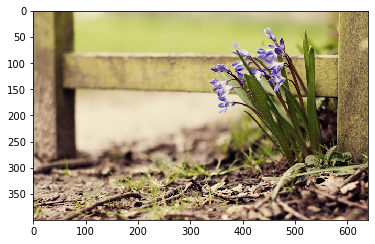

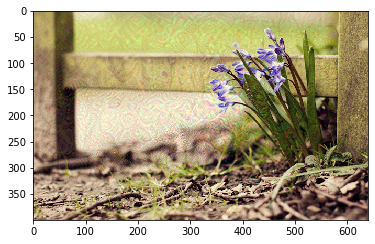

In [112]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()